# Cross-Validation, Overfitting, and Underfitting

This notebook covers three core concepts every ML practitioner must understand before trusting any model:

- **Underfitting**: model is too simple to capture the signal in data
- **Overfitting**: model memorizes training data, fails on new data
- **Cross-Validation**: a principled method to estimate real generalization performance

We build everything from scratch with real demonstrations, not toy diagrams.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import make_classification, load_breast_cancer, make_regression
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold, StratifiedKFold, LeaveOneOut,
    cross_val_score, cross_validate,
    learning_curve, validation_curve
)
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams.update({
    'figure.dpi': 100,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})
print('Libraries loaded.')

Libraries loaded.


---
## Part 1: The Bias-Variance Problem

Before talking about overfitting and underfitting, understand what causes them.

**Bias**: systematic error from wrong assumptions. A linear model on non-linear data has high bias.

**Variance**: sensitivity to fluctuations in training data. A depth-20 tree on 100 samples has high variance.

Total error = Bias² + Variance + Irreducible Noise

- Underfit = High bias, low variance
- Overfit = Low bias, high variance
- Good model = Balanced tradeoff

We cannot eliminate irreducible noise — that's the floor.

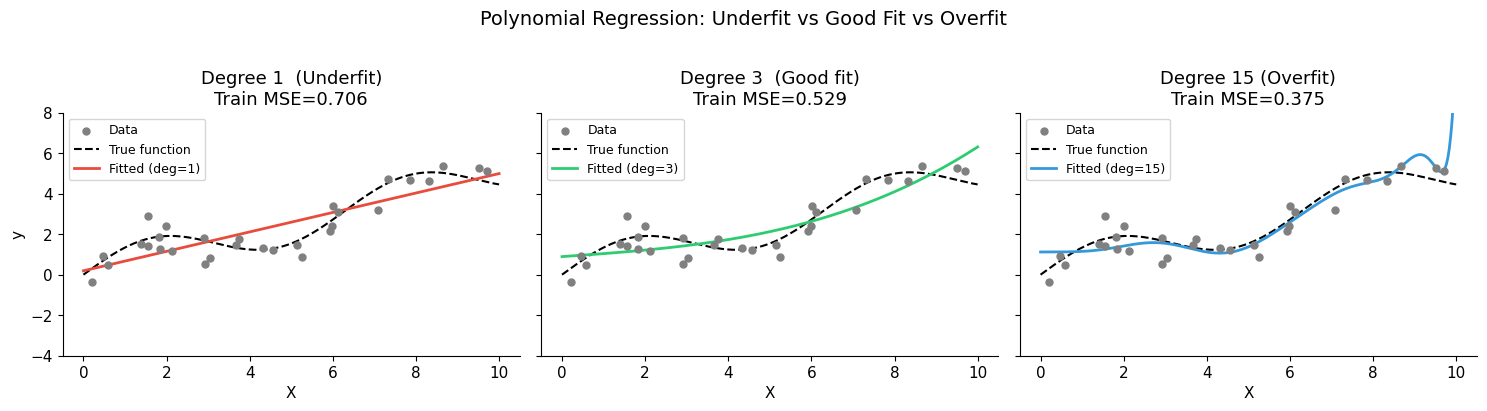

In [2]:
# Generate a 1D regression dataset: true function is sinusoidal
np.random.seed(42)
n = 30
X_1d = np.sort(np.random.uniform(0, 10, n))
y_true = np.sin(X_1d) + 0.5 * X_1d
y_noisy = y_true + np.random.normal(0, 0.6, n)

X_plot = np.linspace(0, 10, 300)
y_plot_true = np.sin(X_plot) + 0.5 * X_plot

degrees = [1, 3, 15]   # underfit, just-right, overfit
labels  = ['Degree 1  (Underfit)', 'Degree 3  (Good fit)', 'Degree 15 (Overfit)']
colors  = ['#e74c3c', '#2ecc71', '#3498db']

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, deg, lbl, col in zip(axes, degrees, labels, colors):
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(X_1d.reshape(-1, 1))
    model = LinearRegression().fit(X_poly, y_noisy)

    X_plot_poly = poly.transform(X_plot.reshape(-1, 1))
    y_pred_plot = model.predict(X_plot_poly)

    y_train_pred = model.predict(X_poly)
    train_mse = mean_squared_error(y_noisy, y_train_pred)

    ax.scatter(X_1d, y_noisy, color='gray', s=25, zorder=5, label='Data')
    ax.plot(X_plot, y_plot_true, 'k--', lw=1.5, label='True function')
    ax.plot(X_plot, y_pred_plot, color=col, lw=2, label=f'Fitted (deg={deg})')
    ax.set_title(f'{lbl}\nTrain MSE={train_mse:.3f}')
    ax.set_xlabel('X')
    ax.legend(fontsize=9)
    ax.set_ylim(-4, 8)

axes[0].set_ylabel('y')
plt.suptitle('Polynomial Regression: Underfit vs Good Fit vs Overfit', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

**What you see above:**
- Degree 1 (red): straight line misses the curve entirely. Low variance, but wrong.
- Degree 3 (green): follows the shape without chasing noise.
- Degree 15 (blue): passes through (or near) every point but wiggles wildly between them. Train MSE is very low but test MSE would be terrible.

---
## Part 2: Train/Test Gap — The Concrete Definition of Overfitting

Overfitting is not subjective. It is measurable: **train accuracy >> test accuracy**.

Below we sweep polynomial degree and track both train and test MSE.

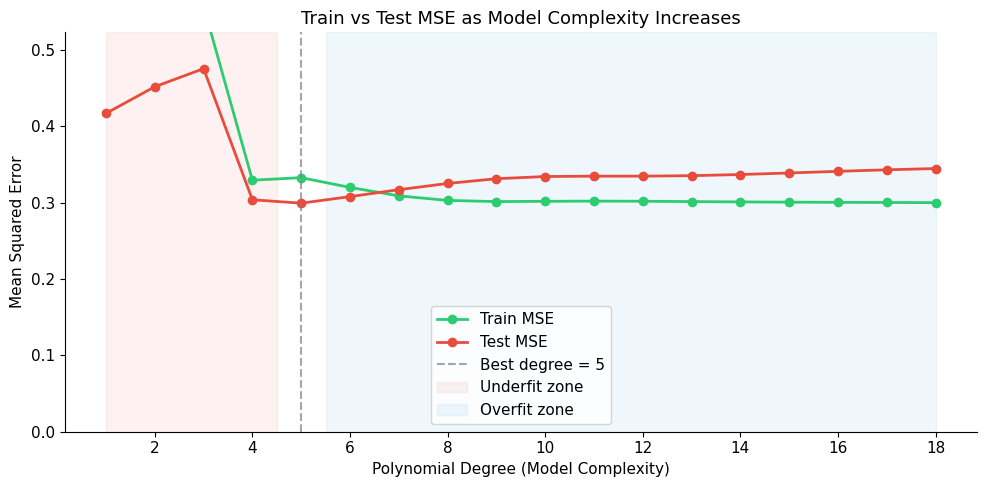

Train MSE at degree 1:  0.6802
Test  MSE at degree 1:  0.4171  <- underfit (both high)
Train MSE at degree 5: 0.3329
Test  MSE at degree 5: 0.2994  <- sweet spot
Train MSE at degree 18: 0.3001
Test  MSE at degree 18: 0.3448  <- overfit (train low, test high)


In [3]:
np.random.seed(42)
n = 50
X_reg = np.sort(np.random.uniform(0, 10, n)).reshape(-1, 1)
y_reg = np.sin(X_reg.ravel()) + 0.5 * X_reg.ravel() + np.random.normal(0, 0.6, n)

X_tr, X_te, y_tr, y_te = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

max_deg = 18
train_mse_list, test_mse_list = [], []

for deg in range(1, max_deg + 1):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=deg)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=0.0001))  # tiny ridge to avoid numerical explosion
    ])
    pipe.fit(X_tr, y_tr)
    train_mse_list.append(mean_squared_error(y_tr, pipe.predict(X_tr)))
    test_mse_list.append(mean_squared_error(y_te, pipe.predict(X_te)))

degrees_range = range(1, max_deg + 1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(degrees_range, train_mse_list, 'o-', color='#2ecc71', lw=2, label='Train MSE')
ax.plot(degrees_range, test_mse_list,  'o-', color='#e74c3c', lw=2, label='Test MSE')

best_deg = np.argmin(test_mse_list) + 1
ax.axvline(best_deg, color='gray', linestyle='--', alpha=0.7, label=f'Best degree = {best_deg}')

ax.fill_betweenx([0, max(test_mse_list)*1.1], 1, best_deg-0.5,
                 alpha=0.07, color='#e74c3c', label='Underfit zone')
ax.fill_betweenx([0, max(test_mse_list)*1.1], best_deg+0.5, max_deg,
                 alpha=0.07, color='#3498db', label='Overfit zone')

ax.set_xlabel('Polynomial Degree (Model Complexity)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Train vs Test MSE as Model Complexity Increases')
ax.legend()
ax.set_ylim(0, max(test_mse_list) * 1.1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

print(f"Train MSE at degree 1:  {train_mse_list[0]:.4f}")
print(f"Test  MSE at degree 1:  {test_mse_list[0]:.4f}  <- underfit (both high)")
print(f"Train MSE at degree {best_deg}: {train_mse_list[best_deg-1]:.4f}")
print(f"Test  MSE at degree {best_deg}: {test_mse_list[best_deg-1]:.4f}  <- sweet spot")
print(f"Train MSE at degree {max_deg}: {train_mse_list[-1]:.4f}")
print(f"Test  MSE at degree {max_deg}: {test_mse_list[-1]:.4f}  <- overfit (train low, test high)")

**Key observation**: As degree increases, train MSE keeps falling. Test MSE falls then rises. The gap between them is the generalization gap — the signature of overfitting.

---
## Part 3: Decision Tree — Depth Controls Overfitting

Decision trees are one of the most intuitive examples. Deeper = more complex = memorizes data.

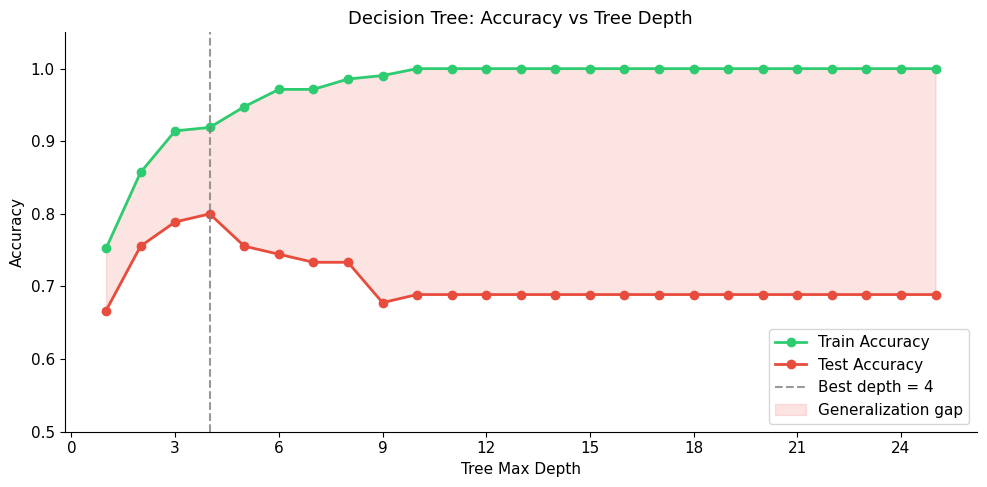

At depth 4:  Train=0.919  Test=0.800
At depth 25:  Train=1.000  Test=0.689  <- clear overfit


In [4]:
X_cls, y_cls = make_classification(
    n_samples=300, n_features=10, n_informative=5,
    n_redundant=2, random_state=42
)
X_tr_c, X_te_c, y_tr_c, y_te_c = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

max_depth_range = range(1, 26)
train_acc, test_acc = [], []

for d in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_tr_c, y_tr_c)
    train_acc.append(accuracy_score(y_tr_c, clf.predict(X_tr_c)))
    test_acc.append(accuracy_score(y_te_c, clf.predict(X_te_c)))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(max_depth_range, train_acc, 'o-', color='#2ecc71', lw=2, label='Train Accuracy')
ax.plot(max_depth_range, test_acc,  'o-', color='#e74c3c', lw=2, label='Test Accuracy')

best_d = max_depth_range[np.argmax(test_acc)]
ax.axvline(best_d, color='gray', linestyle='--', alpha=0.8, label=f'Best depth = {best_d}')

ax.fill_between(max_depth_range, train_acc, test_acc,
                alpha=0.15, color='#e74c3c', label='Generalization gap')

ax.set_xlabel('Tree Max Depth')
ax.set_ylabel('Accuracy')
ax.set_title('Decision Tree: Accuracy vs Tree Depth')
ax.set_ylim(0.5, 1.05)
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

print(f"At depth {best_d}:  Train={train_acc[best_d-1]:.3f}  Test={test_acc[best_d-1]:.3f}")
print(f"At depth 25:  Train={train_acc[-1]:.3f}  Test={test_acc[-1]:.3f}  <- clear overfit")

---
## Part 4: What is Cross-Validation and Why Single Train/Test Split Fails

A single train/test split gives you **one estimate** of test performance. That estimate is noisy — it depends on which 30% happened to end up in your test set.

**Cross-validation** solves this by rotating which portion is the test set.

### K-Fold Cross-Validation

1. Split data into K equal folds
2. For each fold i: train on all folds except i, test on fold i
3. Average the K test scores

You get K estimates of generalization performance. Their mean is more reliable; their std tells you stability.

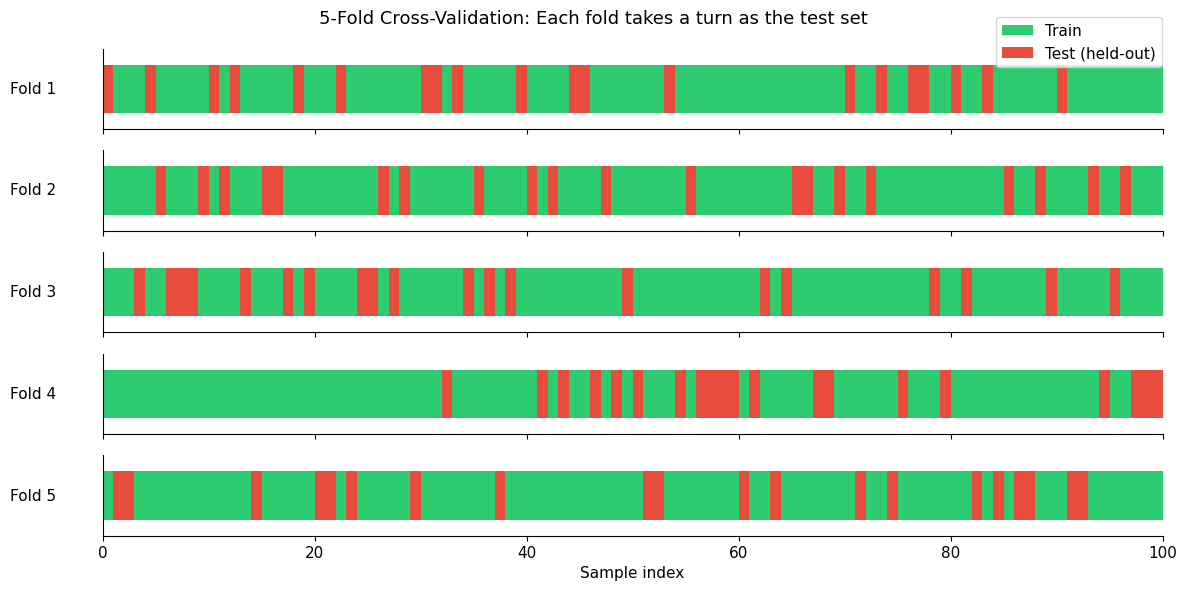

In [5]:
# Visual explanation of K-Fold splits
fig, axes = plt.subplots(5, 1, figsize=(12, 6), sharex=True)
n_samples = 100
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
X_dummy = np.arange(n_samples).reshape(-1, 1)
y_dummy = np.zeros(n_samples)

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_dummy, y_dummy)):
    ax = axes[fold_idx]
    colors_arr = np.array(['#2ecc71'] * n_samples)  # green = train
    colors_arr[test_idx] = '#e74c3c'                 # red = test
    for i, c in enumerate(colors_arr):
        ax.barh(0, 1, left=i, height=0.6, color=c, linewidth=0)
    ax.set_xlim(0, n_samples)
    ax.set_yticks([])
    ax.set_ylabel(f'Fold {fold_idx+1}', rotation=0, labelpad=50, va='center')
    ax.set_ylim(-0.5, 0.5)

axes[-1].set_xlabel('Sample index')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Train'), Patch(facecolor='#e74c3c', label='Test (held-out)')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
plt.suptitle('5-Fold Cross-Validation: Each fold takes a turn as the test set', fontsize=13)
plt.tight_layout()
plt.show()

---
## Part 5: Cross-Validation in Practice — Variance of Single Split vs CV

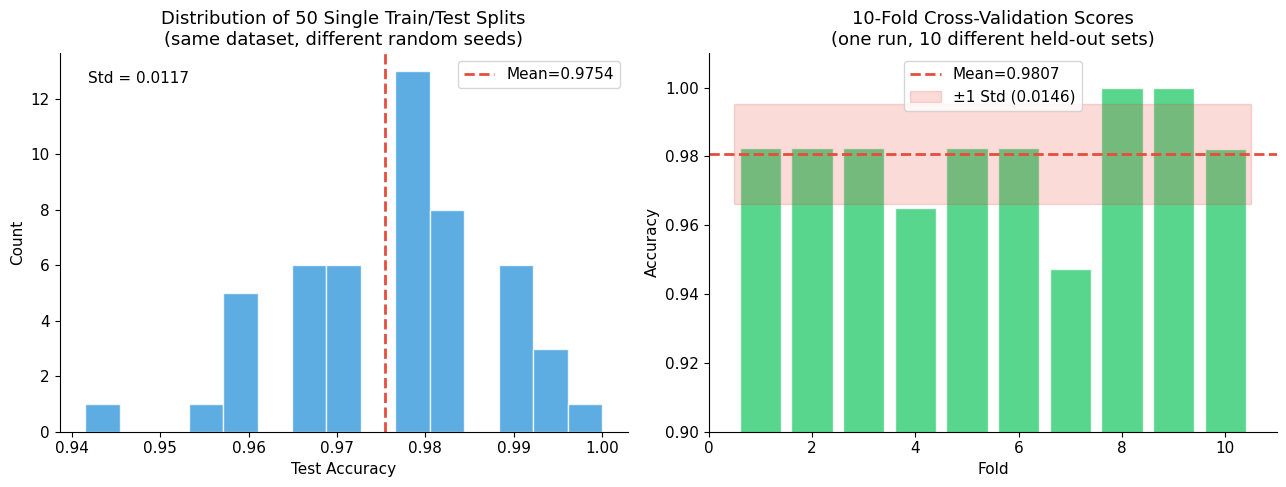

Single split:
  Mean = 0.9754, Std = 0.0117
  Min = 0.9415, Max = 1.0000

10-Fold CV:
  Mean = 0.9807 +/- 0.0146
  Individual folds: [0.9825 0.9825 0.9825 0.9649 0.9825 0.9825 0.9474 1.     1.     0.9821]


In [6]:
# Show that single train/test split is a noisy estimator
# by running it 50 times with different random seeds

data = load_breast_cancer()
X_bc, y_bc = data.data, data.target

clf_bc = LogisticRegression(max_iter=5000, random_state=42)

# 50 random splits
single_split_scores = []
for seed in range(50):
    Xtr, Xte, ytr, yte = train_test_split(X_bc, y_bc, test_size=0.3, random_state=seed)
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xte = scaler.transform(Xte)
    clf_bc.fit(Xtr, ytr)
    single_split_scores.append(accuracy_score(yte, clf_bc.predict(Xte)))

# 10-fold CV (once)
pipe_bc = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=5000))])
cv_scores = cross_val_score(pipe_bc, X_bc, y_bc, cv=10, scoring='accuracy')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: distribution of single-split scores
axes[0].hist(single_split_scores, bins=15, color='#3498db', edgecolor='white', alpha=0.8)
axes[0].axvline(np.mean(single_split_scores), color='#e74c3c', lw=2, linestyle='--',
                label=f'Mean={np.mean(single_split_scores):.4f}')
axes[0].set_title('Distribution of 50 Single Train/Test Splits\n(same dataset, different random seeds)')
axes[0].set_xlabel('Test Accuracy')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].text(0.05, 0.92, f'Std = {np.std(single_split_scores):.4f}',
             transform=axes[0].transAxes, fontsize=11)

# Right: CV fold scores
fold_nums = np.arange(1, len(cv_scores)+1)
axes[1].bar(fold_nums, cv_scores, color='#2ecc71', edgecolor='white', alpha=0.8)
axes[1].axhline(cv_scores.mean(), color='#e74c3c', lw=2, linestyle='--',
                label=f'Mean={cv_scores.mean():.4f}')
axes[1].fill_between([0.5, len(cv_scores)+0.5],
                     cv_scores.mean()-cv_scores.std(),
                     cv_scores.mean()+cv_scores.std(),
                     alpha=0.2, color='#e74c3c', label=f'±1 Std ({cv_scores.std():.4f})')
axes[1].set_title('10-Fold Cross-Validation Scores\n(one run, 10 different held-out sets)')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.9, 1.01)
axes[1].legend()
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print("Single split:")
print(f"  Mean = {np.mean(single_split_scores):.4f}, Std = {np.std(single_split_scores):.4f}")
print(f"  Min = {np.min(single_split_scores):.4f}, Max = {np.max(single_split_scores):.4f}")
print("\n10-Fold CV:")
print(f"  Mean = {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")
print(f"  Individual folds: {cv_scores.round(4)}")

**What this tells you**: With a single split, your reported accuracy can vary by several percentage points depending purely on luck of the split. CV aggregates this variance into a stable estimate with an honest uncertainty interval.

---
## Part 6: Types of Cross-Validation Compared

| Type | How it works | When to use |
|------|--------------|-------------|
| K-Fold | Split into K equal parts, rotate test fold | General purpose |
| Stratified K-Fold | Same but preserves class ratio in each fold | Classification, imbalanced data |
| Leave-One-Out (LOO) | K = N, each sample is a test set once | Very small datasets |
| Repeated K-Fold | Run K-Fold multiple times with different shuffles | Need very stable estimate |

Global class distribution:
  Class 0: 448 (89.6%)
  Class 1: 52 (10.4%)


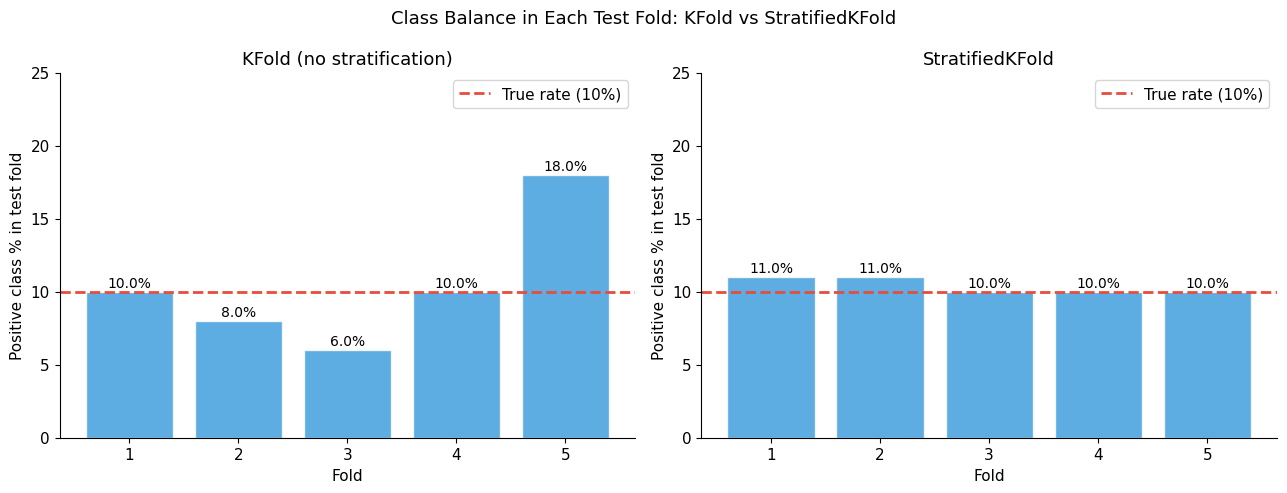

In [7]:
# Compare K-Fold vs Stratified K-Fold on imbalanced dataset
X_imb, y_imb = make_classification(
    n_samples=500, n_features=10, weights=[0.9, 0.1],  # 90/10 imbalance
    random_state=42
)

kf_plain = KFold(n_splits=5, shuffle=True, random_state=42)
kf_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Global class distribution:")
print(f"  Class 0: {(y_imb==0).sum()} ({(y_imb==0).mean()*100:.1f}%)")
print(f"  Class 1: {(y_imb==1).sum()} ({(y_imb==1).mean()*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for ax, kf, title in zip(axes, [kf_plain, kf_strat],
                          ['KFold (no stratification)', 'StratifiedKFold']):
    fold_positives = []
    for fold_i, (tr_idx, te_idx) in enumerate(kf.split(X_imb, y_imb)):
        pos_rate = y_imb[te_idx].mean() * 100
        fold_positives.append(pos_rate)

    folds = np.arange(1, 6)
    ax.bar(folds, fold_positives, color='#3498db', alpha=0.8, edgecolor='white')
    ax.axhline(10, color='#e74c3c', lw=2, linestyle='--', label='True rate (10%)')
    ax.set_ylim(0, 25)
    ax.set_xlabel('Fold')
    ax.set_ylabel('Positive class % in test fold')
    ax.set_title(title)
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for i, v in enumerate(fold_positives):
        ax.text(i+1, v+0.3, f'{v:.1f}%', ha='center', fontsize=10)

plt.suptitle('Class Balance in Each Test Fold: KFold vs StratifiedKFold', fontsize=13)
plt.tight_layout()
plt.show()

**Without stratification**, some folds can have very different class ratios. This inflates the variance of your CV estimate and can give misleading results on imbalanced problems. Always use StratifiedKFold for classification.

---
## Part 7: Learning Curves — Diagnosing Overfit vs Underfit from Data

A learning curve plots model performance vs training set size.

- **Underfitting**: both train and CV score are low and plateau near each other at a poor value
- **Overfitting**: train score is high, CV score is low, and a large gap persists even with more data
- **Good fit**: both converge to a high value as training size grows

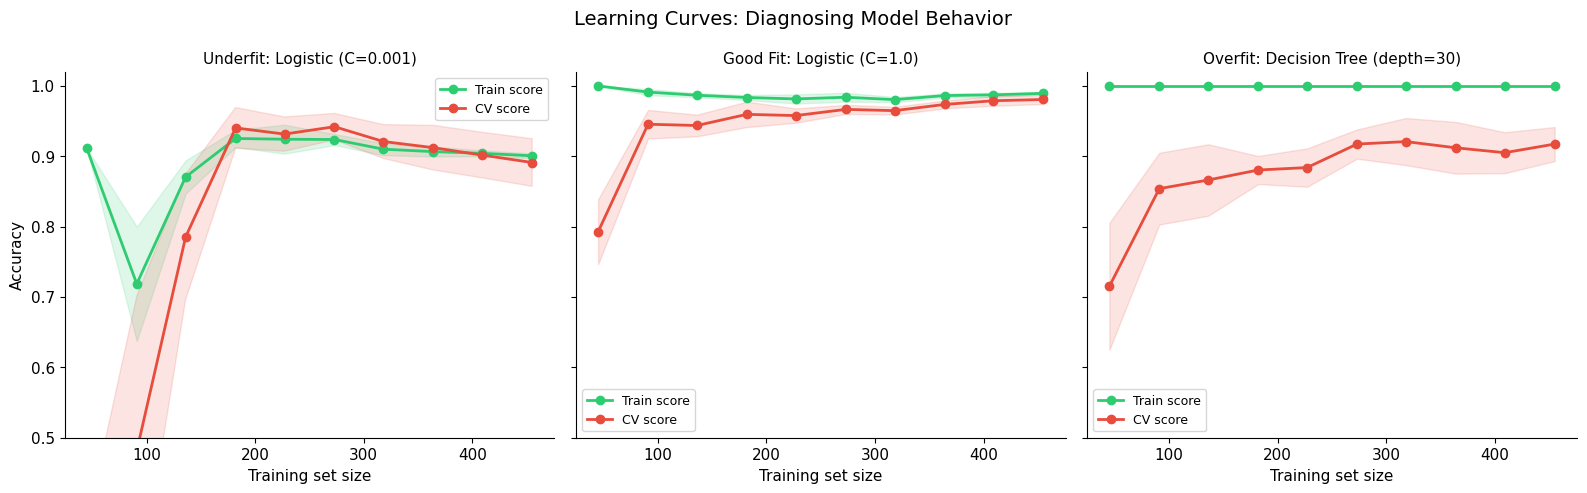

In [8]:
data_bc = load_breast_cancer()
X_lc, y_lc = data_bc.data, data_bc.target

models = {
    'Underfit: Logistic (C=0.001)':    Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression(C=0.001, max_iter=1000))]),
    'Good Fit: Logistic (C=1.0)':       Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression(C=1.0,   max_iter=1000))]),
    'Overfit: Decision Tree (depth=30)': DecisionTreeClassifier(max_depth=30, random_state=42)
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
train_sizes_pct = np.linspace(0.1, 1.0, 10)

for ax, (title, model) in zip(axes, models.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_lc, y_lc,
        train_sizes=train_sizes_pct,
        cv=5, scoring='accuracy', n_jobs=-1
    )

    tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    va_mean, va_std = val_scores.mean(axis=1),   val_scores.std(axis=1)

    ax.plot(train_sizes, tr_mean, 'o-', color='#2ecc71', lw=2, label='Train score')
    ax.fill_between(train_sizes, tr_mean - tr_std, tr_mean + tr_std, alpha=0.15, color='#2ecc71')

    ax.plot(train_sizes, va_mean, 'o-', color='#e74c3c', lw=2, label='CV score')
    ax.fill_between(train_sizes, va_mean - va_std, va_mean + va_std, alpha=0.15, color='#e74c3c')

    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Training set size')
    ax.set_ylim(0.5, 1.02)
    ax.legend(fontsize=9)

axes[0].set_ylabel('Accuracy')
plt.suptitle('Learning Curves: Diagnosing Model Behavior', fontsize=14)
plt.tight_layout()
plt.show()

**Reading learning curves:**

- Underfit: both lines converge low. More data won't help — the model is too constrained.
- Good fit: both lines converge high with a small gap.
- Overfit: train stays high, CV stays low. Large persistent gap. More data would help (the gap shrinks as n grows).

---
## Part 8: Validation Curves — Hyperparameter Tuning with CV

Instead of train/test split, use CV at each hyperparameter value to find the best configuration without leaking test data.

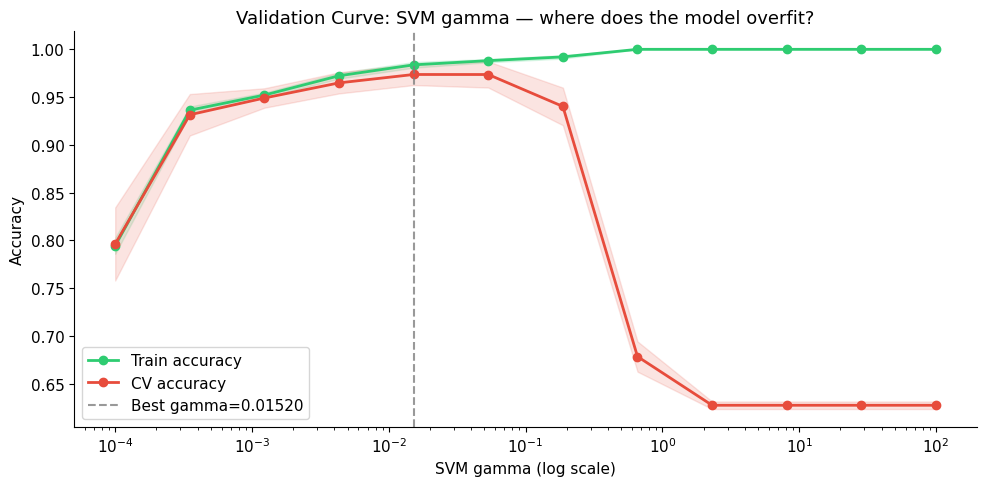

Best gamma (by CV): 0.015199
Best CV accuracy:   0.9737 +/- 0.0111


In [9]:
# Validation curve: SVM kernel coefficient (gamma) on breast cancer
pipe_svm = Pipeline([('sc', StandardScaler()), ('svm', SVC(kernel='rbf'))])

param_range = np.logspace(-4, 2, 12)

train_sc, val_sc = validation_curve(
    pipe_svm, X_lc, y_lc,
    param_name='svm__gamma',
    param_range=param_range,
    cv=5, scoring='accuracy', n_jobs=-1
)

tr_m, tr_s = train_sc.mean(axis=1), train_sc.std(axis=1)
va_m, va_s = val_sc.mean(axis=1),   val_sc.std(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogx(param_range, tr_m, 'o-', color='#2ecc71', lw=2, label='Train accuracy')
ax.fill_between(param_range, tr_m - tr_s, tr_m + tr_s, alpha=0.15, color='#2ecc71')
ax.semilogx(param_range, va_m, 'o-', color='#e74c3c', lw=2, label='CV accuracy')
ax.fill_between(param_range, va_m - va_s, va_m + va_s, alpha=0.15, color='#e74c3c')

best_gamma = param_range[np.argmax(va_m)]
ax.axvline(best_gamma, color='gray', linestyle='--', alpha=0.8, label=f'Best gamma={best_gamma:.5f}')

ax.set_xlabel('SVM gamma (log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Validation Curve: SVM gamma — where does the model overfit?')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Best gamma (by CV): {best_gamma:.6f}")
print(f"Best CV accuracy:   {va_m.max():.4f} +/- {va_s[np.argmax(va_m)]:.4f}")

---
## Part 9: Comparing Multiple Models with CV — The Right Way

Never compare models using a single train/test split. Use CV for every model and compare distributions.

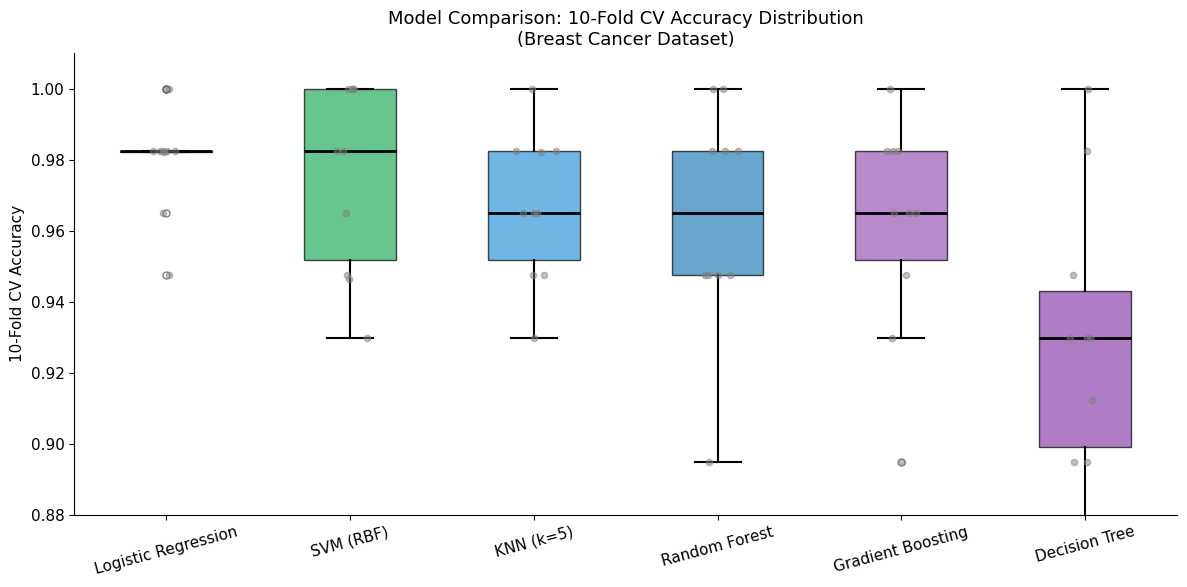

Model comparison summary:
Model                         Mean      Std      Min      Max
------------------------------------------------------------
Logistic Regression         0.9807   0.0154   0.9474   1.0000
SVM (RBF)                   0.9753   0.0265   0.9298   1.0000
KNN (k=5)                   0.9666   0.0210   0.9298   1.0000
Random Forest               0.9632   0.0325   0.8947   1.0000
Gradient Boosting           0.9614   0.0307   0.8947   1.0000
Decision Tree               0.9281   0.0417   0.8596   1.0000


In [10]:
models_compare = {
    'Logistic Regression':   Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))]),
    'Decision Tree':         DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest':         RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)':             Pipeline([('sc', StandardScaler()), ('clf', SVC(kernel='rbf', gamma='scale'))]),
    'KNN (k=5)':             Pipeline([('sc', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=5))]),
    'Gradient Boosting':     GradientBoostingClassifier(n_estimators=100, random_state=42)
}

cv_results = {}
for name, model in models_compare.items():
    scores = cross_val_score(model, X_lc, y_lc, cv=10, scoring='accuracy', n_jobs=-1)
    cv_results[name] = scores

results_df = pd.DataFrame(cv_results)
means = results_df.mean().sort_values(ascending=False)
results_sorted = results_df[means.index]

fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(
    [results_sorted[c].values for c in results_sorted.columns],
    labels=results_sorted.columns,
    patch_artist=True,
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, alpha=0.5)
)

palette = ['#2ecc71', '#27ae60', '#3498db', '#2980b9', '#9b59b6', '#8e44ad']
for patch, color in zip(bp['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Overlay individual points
for i, col in enumerate(results_sorted.columns):
    y = results_sorted[col].values
    x = np.random.normal(i + 1, 0.05, size=len(y))
    ax.scatter(x, y, alpha=0.5, s=20, color='gray', zorder=5)

ax.set_ylabel('10-Fold CV Accuracy')
ax.set_title('Model Comparison: 10-Fold CV Accuracy Distribution\n(Breast Cancer Dataset)')
ax.set_ylim(0.88, 1.01)
ax.tick_params(axis='x', rotation=15)
plt.tight_layout()
plt.show()

print("Model comparison summary:")
print(f"{'Model':<25} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print('-' * 60)
for col in means.index:
    sc = results_sorted[col]
    print(f"{col:<25} {sc.mean():>8.4f} {sc.std():>8.4f} {sc.min():>8.4f} {sc.max():>8.4f}")

---
## Part 10: Regularization — The Practical Fix for Overfitting

When you detect overfitting, the response is regularization: penalize model complexity during training.

For linear models:
- **L2 (Ridge)**: shrinks all coefficients toward zero
- **L1 (Lasso)**: drives some coefficients exactly to zero (feature selection)
- **ElasticNet**: combination of both

The regularization strength `C` (or `alpha`) is a hyperparameter tuned via CV.

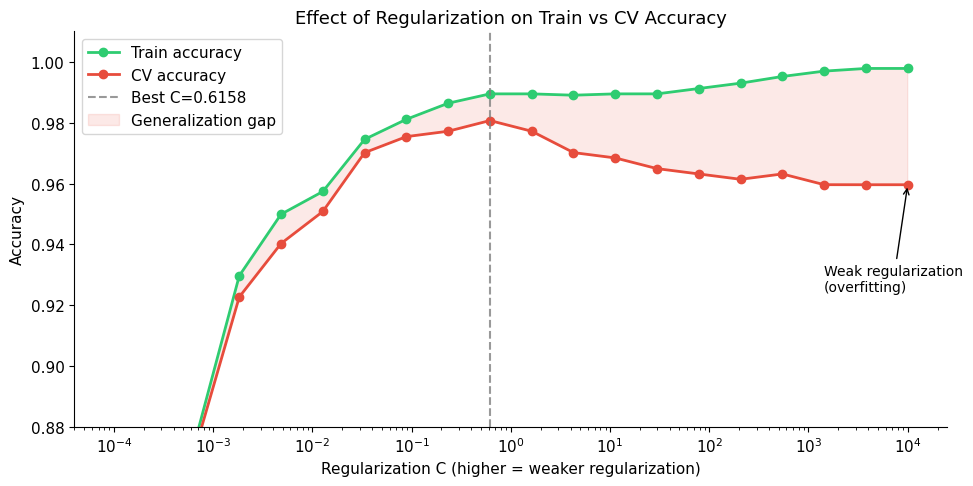

Best C: 0.615848  ->  CV accuracy: 0.9807


In [11]:
# Effect of regularization C on logistic regression
C_range = np.logspace(-4, 4, 20)

tr_scores, cv_scores_reg = [], []
for C in C_range:
    pipe_lr = Pipeline([
        ('sc', StandardScaler()),
        ('clf', LogisticRegression(C=C, max_iter=2000, random_state=42))
    ])
    cv_s = cross_validate(pipe_lr, X_lc, y_lc, cv=5, scoring='accuracy',
                          return_train_score=True, n_jobs=-1)
    tr_scores.append(cv_s['train_score'].mean())
    cv_scores_reg.append(cv_s['test_score'].mean())

tr_scores = np.array(tr_scores)
cv_scores_reg = np.array(cv_scores_reg)

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogx(C_range, tr_scores, 'o-', color='#2ecc71', lw=2, label='Train accuracy')
ax.semilogx(C_range, cv_scores_reg, 'o-', color='#e74c3c', lw=2, label='CV accuracy')

best_C = C_range[np.argmax(cv_scores_reg)]
ax.axvline(best_C, color='gray', linestyle='--', alpha=0.8, label=f'Best C={best_C:.4f}')

ax.fill_between(C_range, tr_scores, cv_scores_reg,
                alpha=0.12, color='#e74c3c', label='Generalization gap')

ax.annotate('Strong regularization\n(underfitting)', xy=(C_range[2], cv_scores_reg[2]),
            xytext=(C_range[0], cv_scores_reg[2]-0.04),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

ax.annotate('Weak regularization\n(overfitting)', xy=(C_range[-1], cv_scores_reg[-1]),
            xytext=(C_range[-3], cv_scores_reg[-1]-0.035),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

ax.set_xlabel('Regularization C (higher = weaker regularization)')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Regularization on Train vs CV Accuracy')
ax.legend()
ax.set_ylim(0.88, 1.01)
plt.tight_layout()
plt.show()

print(f"Best C: {best_C:.6f}  ->  CV accuracy: {cv_scores_reg.max():.4f}")

---
## Part 11: Nested Cross-Validation — Proper Hyperparameter Tuning

**The problem**: if you tune hyperparameters using CV, then evaluate on the same data, you've leaked information. The CV score is now optimistically biased.

**The solution**: Nested CV
- **Outer loop**: estimates generalization performance
- **Inner loop**: selects the best hyperparameter for each outer fold

This gives an honest estimate of how well a model selected by your tuning procedure will generalize.

Naive CV (tune and evaluate on same data):
  Best score (optimistic): 0.9789
  Best params: {'svm__C': 10, 'svm__gamma': 0.01}

Nested CV (honest estimate):
  Outer fold scores: [1.     0.9474 0.9825 0.9912 0.9823]
  Mean: 0.9807 +/- 0.0179

Optimism bias of naive approach: +-0.0017


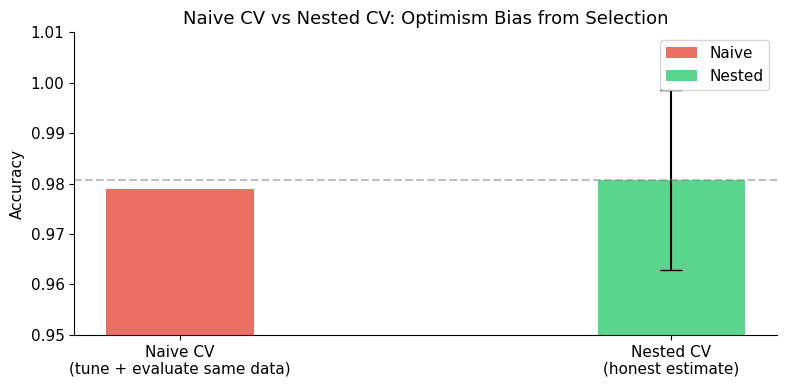

In [12]:
from sklearn.model_selection import GridSearchCV

# Compare: naive CV (tune then evaluate on same data) vs nested CV
X_nest, y_nest = load_breast_cancer(return_X_y=True)
pipe_nest = Pipeline([('sc', StandardScaler()), ('svm', SVC(kernel='rbf'))])
param_grid = {'svm__C': [0.1, 1, 10, 100], 'svm__gamma': [0.001, 0.01, 0.1]}

# Naive: tune with 5-fold, report that CV score
gs = GridSearchCV(pipe_nest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_nest, y_nest)
naive_score = gs.best_score_

# Nested: outer 5-fold, inner 5-fold for tuning
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(
    GridSearchCV(pipe_nest, param_grid, cv=5, scoring='accuracy', n_jobs=-1),
    X_nest, y_nest, cv=outer_cv, scoring='accuracy'
)

print("Naive CV (tune and evaluate on same data):")
print(f"  Best score (optimistic): {naive_score:.4f}")
print(f"  Best params: {gs.best_params_}")
print()
print("Nested CV (honest estimate):")
print(f"  Outer fold scores: {nested_scores.round(4)}")
print(f"  Mean: {nested_scores.mean():.4f} +/- {nested_scores.std():.4f}")
print()
print(f"Optimism bias of naive approach: +{naive_score - nested_scores.mean():.4f}")

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['Naive CV\n(tune + evaluate same data)'], [naive_score],
       color='#e74c3c', alpha=0.8, width=0.3, label='Naive')
ax.bar(['Nested CV\n(honest estimate)'], [nested_scores.mean()],
       color='#2ecc71', alpha=0.8, width=0.3, label='Nested',
       yerr=nested_scores.std(), capsize=8)

ax.set_ylabel('Accuracy')
ax.set_title('Naive CV vs Nested CV: Optimism Bias from Selection')
ax.set_ylim(0.95, 1.01)
ax.axhline(nested_scores.mean(), color='gray', linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

---
## Part 12: K-Fold K Parameter — How Many Folds?

Choosing K involves a tradeoff:

- **Low K (e.g. K=3)**: each fold tests on 33% of data. High bias (less training data per fold), low variance, fast.
- **High K (e.g. K=20)**: each fold tests on 5% of data. Lower bias, higher variance, slow.
- **K=10**: standard in practice, good balance.
- **LOO (K=N)**: near-unbiased but very high variance and slow for large N.

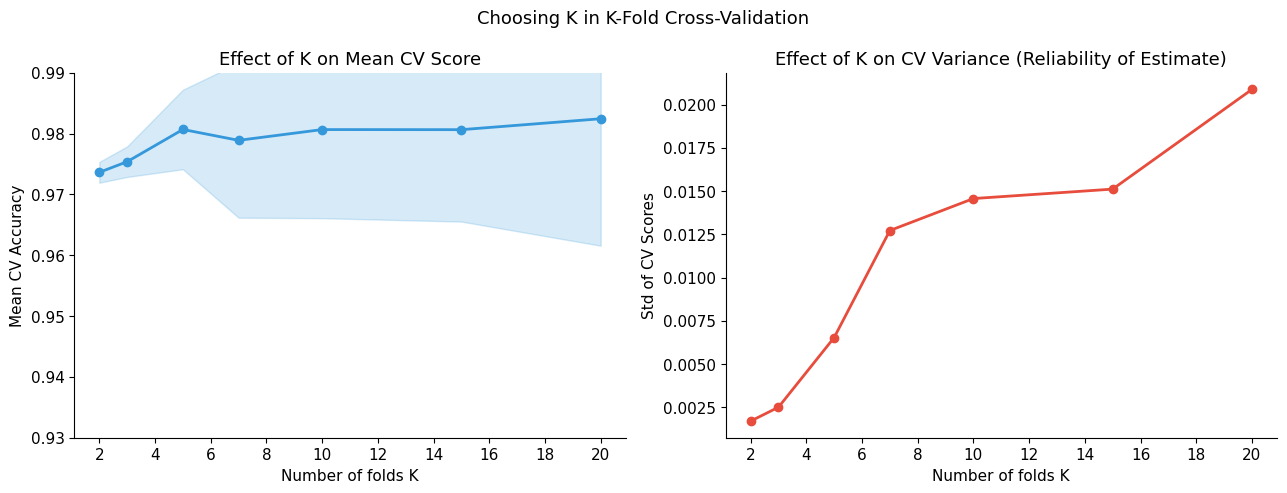

    K       Mean        Std
----------------------------
    2     0.9736     0.0017
    3     0.9754     0.0025
    5     0.9807     0.0065
    7     0.9789     0.0127
   10     0.9807     0.0146
   15     0.9807     0.0151
   20     0.9825     0.0209


In [13]:
# How K affects mean and std of CV estimate
k_values = [2, 3, 5, 7, 10, 15, 20]
pipe_k = Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])

cv_means, cv_stds = [], []

for k in k_values:
    scores = cross_val_score(pipe_k, X_lc, y_lc, cv=k, scoring='accuracy')
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(k_values, cv_means, 'o-', color='#3498db', lw=2)
axes[0].fill_between(k_values, cv_means - cv_stds, cv_means + cv_stds,
                     alpha=0.2, color='#3498db')
axes[0].set_xlabel('Number of folds K')
axes[0].set_ylabel('Mean CV Accuracy')
axes[0].set_title('Effect of K on Mean CV Score')
axes[0].set_ylim(0.93, 0.99)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[1].plot(k_values, cv_stds, 'o-', color='#e74c3c', lw=2)
axes[1].set_xlabel('Number of folds K')
axes[1].set_ylabel('Std of CV Scores')
axes[1].set_title('Effect of K on CV Variance (Reliability of Estimate)')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.suptitle('Choosing K in K-Fold Cross-Validation', fontsize=13)
plt.tight_layout()
plt.show()

print(f"{'K':>5} {'Mean':>10} {'Std':>10}")
print('-' * 28)
for k, m, s in zip(k_values, cv_means, cv_stds):
    print(f"{k:>5} {m:>10.4f} {s:>10.4f}")

---
## Part 13: Summary — Rules of Thumb

**Diagnosing your model:**

| Symptom | Diagnosis | Fix |
|---------|-----------|-----|
| Train error high, CV error high | Underfitting | More complex model, more features |
| Train error low, CV error high | Overfitting | Regularization, more data, simpler model |
| Both errors high and equal | Underfit | Increase model capacity |
| Both errors low and close | Good generalization | Done |

**Cross-validation checklist:**
- Always use StratifiedKFold for classification
- K=10 is the default unless data is very small (use LOO) or very large (use K=3-5)
- Include all preprocessing (scaling, imputation) inside the CV pipeline to prevent data leakage
- Use nested CV when selecting hyperparameters — naive CV is optimistically biased
- Compare models by distribution (boxplot) not just mean score

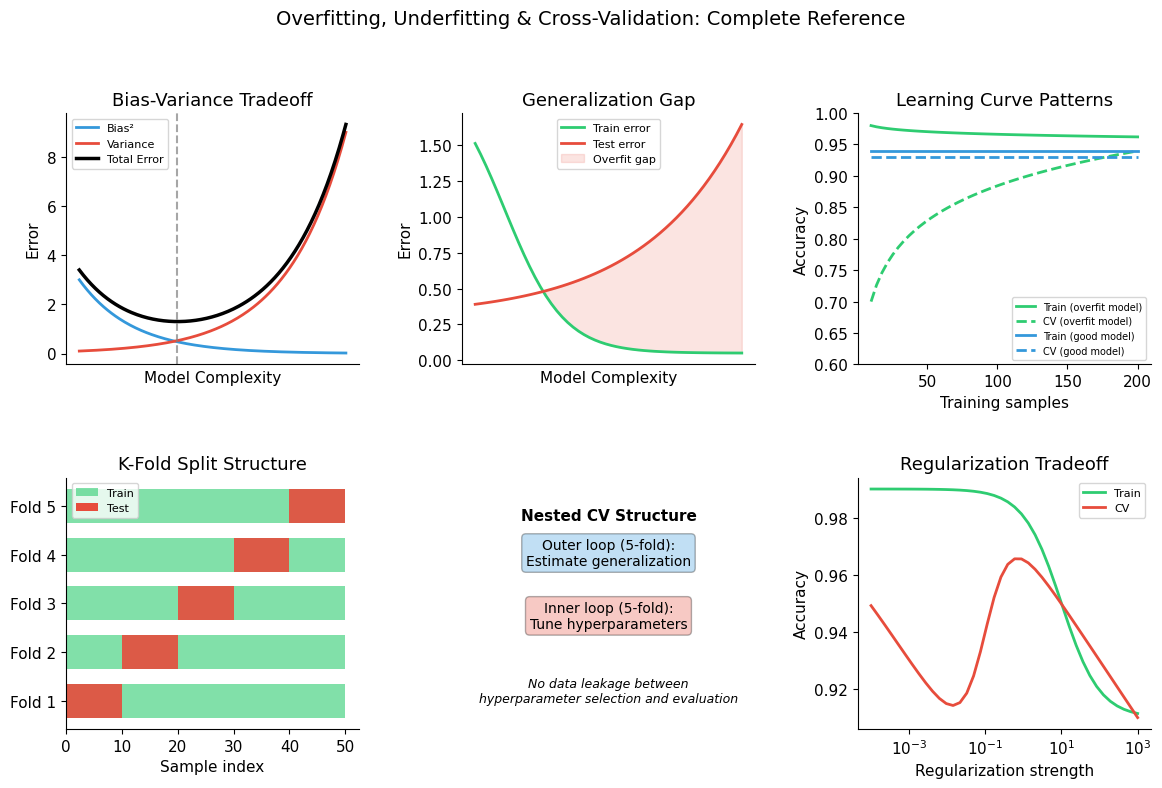

Summary plot saved as summary_reference.png


In [14]:
# Final summary visualization: the complete picture
fig = plt.figure(figsize=(14, 8))
gs_fig = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.35)

# 1. Bias-Variance concept curve (analytical)
ax1 = fig.add_subplot(gs_fig[0, 0])
complexity = np.linspace(0, 10, 200)
bias2 = 3 * np.exp(-0.5 * complexity)
variance = 0.1 * np.exp(0.45 * complexity)
total = bias2 + variance + 0.3
ax1.plot(complexity, bias2, color='#3498db', lw=2, label='Bias²')
ax1.plot(complexity, variance, color='#e74c3c', lw=2, label='Variance')
ax1.plot(complexity, total, 'k-', lw=2.5, label='Total Error')
ax1.axvline(complexity[np.argmin(total)], color='gray', linestyle='--', alpha=0.7)
ax1.set_xlabel('Model Complexity')
ax1.set_ylabel('Error')
ax1.set_title('Bias-Variance Tradeoff')
ax1.legend(fontsize=8)
ax1.set_xticks([])

# 2. Train/test gap curve
ax2 = fig.add_subplot(gs_fig[0, 1])
comp2 = np.linspace(1, 10, 50)
tr_err = 2 / (1 + np.exp(comp2 - 2)) + 0.05
te_err = 0.4 + 0.3 * np.exp(0.3*(comp2-5)) - 0.1
ax2.plot(comp2, tr_err, color='#2ecc71', lw=2, label='Train error')
ax2.plot(comp2, te_err, color='#e74c3c', lw=2, label='Test error')
ax2.fill_between(comp2, tr_err, te_err, where=(te_err>tr_err), alpha=0.15, color='#e74c3c', label='Overfit gap')
ax2.set_xlabel('Model Complexity')
ax2.set_ylabel('Error')
ax2.set_title('Generalization Gap')
ax2.legend(fontsize=8)
ax2.set_xticks([])

# 3. Learning curve shape concepts
ax3 = fig.add_subplot(gs_fig[0, 2])
n_pts = np.linspace(10, 200, 50)
tr_over  = 0.98 - 0.02 * np.log(n_pts/10) * 0.3
cv_over  = 0.70 + 0.10 * np.log(n_pts/10) * 0.8
ax3.plot(n_pts, tr_over, color='#2ecc71', lw=2, linestyle='-',  label='Train (overfit model)')
ax3.plot(n_pts, cv_over, color='#2ecc71', lw=2, linestyle='--', label='CV (overfit model)')
tr_good = 0.95 - 0.01 * np.ones_like(n_pts)
cv_good = 0.92 + 0.01 * np.ones_like(n_pts)
ax3.plot(n_pts, tr_good, color='#3498db', lw=2, linestyle='-',  label='Train (good model)')
ax3.plot(n_pts, cv_good, color='#3498db', lw=2, linestyle='--', label='CV (good model)')
ax3.set_xlabel('Training samples')
ax3.set_ylabel('Accuracy')
ax3.set_title('Learning Curve Patterns')
ax3.legend(fontsize=7)
ax3.set_ylim(0.6, 1.0)

# 4. KFold diagram
ax4 = fig.add_subplot(gs_fig[1, 0])
n_samp = 50
k_diag = 5
fold_size = n_samp // k_diag
for fold in range(k_diag):
    test_start = fold * fold_size
    test_end = test_start + fold_size
    ax4.barh(fold, n_samp, color='#2ecc71', alpha=0.6, height=0.7)
    ax4.barh(fold, fold_size, left=test_start, color='#e74c3c', alpha=0.9, height=0.7)
ax4.set_yticks(range(k_diag))
ax4.set_yticklabels([f'Fold {i+1}' for i in range(k_diag)])
ax4.set_xlabel('Sample index')
ax4.set_title('K-Fold Split Structure')
from matplotlib.patches import Patch as P
ax4.legend(handles=[P(facecolor='#2ecc71', alpha=0.6, label='Train'), P(facecolor='#e74c3c', label='Test')], fontsize=8)

# 5. Nested CV diagram
ax5 = fig.add_subplot(gs_fig[1, 1])
ax5.text(0.5, 0.85, 'Nested CV Structure', ha='center', va='center', fontsize=11, weight='bold',
         transform=ax5.transAxes)
ax5.text(0.5, 0.7, 'Outer loop (5-fold):\nEstimate generalization', ha='center', va='center',
         fontsize=10, transform=ax5.transAxes,
         bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.3))
ax5.text(0.5, 0.45, 'Inner loop (5-fold):\nTune hyperparameters', ha='center', va='center',
         fontsize=10, transform=ax5.transAxes,
         bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.3))
ax5.text(0.5, 0.15, 'No data leakage between\nhyperparameter selection and evaluation', ha='center',
         va='center', fontsize=9, transform=ax5.transAxes, style='italic')
ax5.axis('off')

# 6. Regularization effect
ax6 = fig.add_subplot(gs_fig[1, 2])
reg_str = np.logspace(-4, 3, 40)
tr_r = 0.99 - 0.08 / (1 + np.exp(-2 * (np.log10(reg_str) - 1)))
cv_r = 0.87 + 0.10 / (1 + np.exp(-3 * (np.log10(reg_str) + 1))) - 0.02 * np.log10(reg_str + 1e-5)
cv_r = np.clip(cv_r, 0.84, 0.97)
ax6.semilogx(reg_str, tr_r, color='#2ecc71', lw=2, label='Train')
ax6.semilogx(reg_str, cv_r, color='#e74c3c', lw=2, label='CV')
ax6.set_xlabel('Regularization strength')
ax6.set_ylabel('Accuracy')
ax6.set_title('Regularization Tradeoff')
ax6.legend(fontsize=8)

plt.suptitle('Overfitting, Underfitting & Cross-Validation: Complete Reference', fontsize=14, y=1.01)
plt.savefig('summary_reference.png', dpi=120, bbox_inches='tight')
plt.show()
print('Summary plot saved as summary_reference.png')

---
## Appendix: Practical Checklist Before Reporting Any CV Score

1. **Is preprocessing inside the pipeline?** If you fit a scaler on the full dataset before CV, you have data leakage.
2. **Did you use StratifiedKFold?** Required for classification.
3. **Are you comparing means or distributions?** Two models with similar means but one has 10x higher std is a real difference.
4. **Are you doing hyperparameter selection?** Use nested CV or hold out a final test set that was never touched during tuning.
5. **What is the baseline?** A model that always predicts the majority class. Your model must beat it substantially.
6. **Does the CV std make sense?** If std > 5%, your model is unstable — investigate class imbalance or data quality.

In [15]:
# Quick data leakage demonstration: scaling before vs inside CV
pipe_correct = Pipeline([('sc', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])

# Wrong way: scale entire dataset first, then CV
scaler_global = StandardScaler()
X_scaled_global = scaler_global.fit_transform(X_lc)  # <-- leak: test fold stats included
clf_wrong = LogisticRegression(max_iter=1000)

correct_cv = cross_val_score(pipe_correct, X_lc, y_lc, cv=10, scoring='accuracy')
wrong_cv   = cross_val_score(clf_wrong, X_scaled_global, y_lc, cv=10, scoring='accuracy')

print("Data leakage comparison (scaling before vs inside CV):")
print(f"Correct (scaling inside pipeline): {correct_cv.mean():.4f} +/- {correct_cv.std():.4f}")
print(f"Wrong   (scaling before CV):       {wrong_cv.mean():.4f}   +/- {wrong_cv.std():.4f}")
print()
print("On this dataset the difference is small, but on small/shifted datasets")
print("data leakage can inflate reported accuracy by several percentage points.")
print("Always use Pipeline to prevent it.")

Data leakage comparison (scaling before vs inside CV):
Correct (scaling inside pipeline): 0.9807 +/- 0.0146
Wrong   (scaling before CV):       0.9807   +/- 0.0146

On this dataset the difference is small, but on small/shifted datasets
data leakage can inflate reported accuracy by several percentage points.
Always use Pipeline to prevent it.


If this notebook helped you understand cross-validation, overfitting, and underfitting — consider leaving an upvote. It helps others find the work and keeps me motivated to create more.

Thank you for reading.